In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

from utils import standardize_data
from plotting import plot_flow, plot_velocity_grid

from models import lsnm_model
from training import fit_sm_bd

jax.config.update("jax_threefry_partitionable", False)

In [2]:
from mechanisms import mechanism_from_flow

class estimated_flow(mechanism_from_flow):

    def __init__(self, model, params):
        super().__init__(stiff = False)
        self.model = model
        self.params = params

    def velocity(self, y, x):
        return self.model(y, x, self.params)
    
from mechanisms import flow_from_mechanism

class nn_conditioner_mechanism(flow_from_mechanism):

    def __init__(self, mech = "anm", **kwargs):
        super().__init__()
        assert mech in ["anm", "lsnm"], "mech must be either 'anm' or 'lsnm'."
        self.mech = mech
        if mech == "anm":
            n_out = 1
        elif mech == "lsnm":
            n_out = 2
        self.build_nn_params(n_out, **kwargs)

    def build_nn_params(self, n_out, layers = 3, hidden_size = 64, seed = 0, init_weight = 0.4):
        params = {"w1": jax.random.normal(shape=(1, hidden_size), key=jax.random.PRNGKey(seed))*init_weight,
                    "b1": jax.random.normal(shape=(hidden_size), key=jax.random.PRNGKey(seed + 1))*init_weight}
        for i in range(layers - 2):
            params[f"w{i+2}"] = jax.random.normal(shape=(hidden_size, hidden_size), key=jax.random.PRNGKey(seed))*init_weight
            params[f"b{i+2}"] = jax.random.normal(shape=(hidden_size), key=jax.random.PRNGKey(seed + 1))*init_weight
            seed = seed + 2
        params[f"w{layers}"] = jax.random.normal(shape=(hidden_size, n_out), key=jax.random.PRNGKey(seed))*init_weight
        params[f"b{layers}"] = jax.random.normal(shape=(n_out), key=jax.random.PRNGKey(seed + 1))*init_weight
        self.params = params
        self.layers = layers

    def nn_conditioner(self, x):
        x = jnp.array(x)
        if x.ndim == 1:
            x = x[:, None]
        h = x
        for i in range(self.layers-1):
            h = jnp.dot(h, self.params[f"w{i+1}"]) + self.params[f"b{i+1}"]
            h = jax.nn.tanh(h)
        out = jnp.dot(h, self.params[f"w{self.layers}"]) + self.params[f"b{self.layers}"]
        return out

    def forward(self, x, e):
        """
        compute y = f_{x}(e)
        """
        cond = self.nn_conditioner(x)
        if self.mech == "anm":
            return (e + cond.squeeze()).squeeze()
        elif self.mech == "lsnm":
            mu, sigma = cond[:, 0], jnp.exp(cond[:, 1])
            return (mu + (sigma+0.1) * e).squeeze()

    def inverse(self, x, y):
        """
        compute e = f^{-1}_x(y) 
        """
        cond = self.nn_conditioner(x)
        if self.mech == "anm":
            return (y - cond.squeeze()).squeeze()
        elif self.mech == "lsnm":
            mu, sigma = cond[:, 0], jnp.exp(cond[:, 1])
            return ((y - mu)/(sigma+0.1)).squeeze()
        
lsnm = nn_conditioner_mechanism(mech = "lsnm", seed = 1)


In [3]:
N_DATA = 10000
DATA_SEED = 0

x_data = jax.random.normal(shape = (N_DATA,), key = jax.random.PRNGKey(DATA_SEED))
noise = jax.random.normal(shape = (N_DATA,), key = jax.random.PRNGKey(DATA_SEED + 1))
y_data = lsnm.forward(x_data, noise)

dat = jnp.concat((x_data[:, None], y_data[:, None]), axis = -1)


dat, dat_mean, dat_std = standardize_data(dat, return_statistics = True, trim_outliers = 0.01) 
x_data, x_data_mean, x_data_std = dat[:,0], dat_mean[0], dat_std[0]
y_data, y_data_mean, y_data_std = dat[:,1], dat_mean[1], dat_std[1]

## the statistics can be passed to the lsnm object to also standardize the flow and velocity:

lsnm.set_normalization_statistics(x_data_mean, x_data_std, y_data_mean, y_data_std)

def gaussian_score_oracle(x, y, model):
    """
    Computes the ground truth sx, sxy given gaussian noise and mechanism "model". 
    """
    e = model.inverse_normalized(x, y)
    df = jax.vmap(jax.grad(model.inverse_normalized, (0, 1))) ## returns tuple (df-1/dx, df-1/dy)
    dfdy = jax.grad(model.inverse_normalized, 1)
    dfdxdy = jax.vmap(jax.grad(dfdy, (0,1))) ## returns tuple (d^2f-1/dxdy, d^2f-1/dy^2)

    dx_data, dy_data = df(x, y)
    dxdy_data, dydy_data = dfdxdy(x, y)

    sx = -x_data ## std. gaussian score 
    sxyx = -x_data + (-e)*(dx_data) + dxdy_data/dy_data
    sxyy = - e * dy_data + dydy_data/dy_data

    sxy = jnp.stack((sxyx, sxyy), axis = -1)

    def marginal_y(y_):
        e = jax.vmap(model.inverse_normalized, (0, None))(x, y_)
        dfdy_data = jnp.abs(jax.vmap(jax.grad(model.inverse_normalized, 1), (0, None))(x, y_))
        return (-(e)*dfdy_data).mean(axis = 0).squeeze()
    
    py = jax.vmap(marginal_y)(y)
    sy = jax.vmap(jax.grad(lambda _: jnp.log(marginal_y(_))))(y)

    return sx, sy, sxy

sx_data, sy_data, sxy_data = gaussian_score_oracle(x_data, y_data, lsnm)


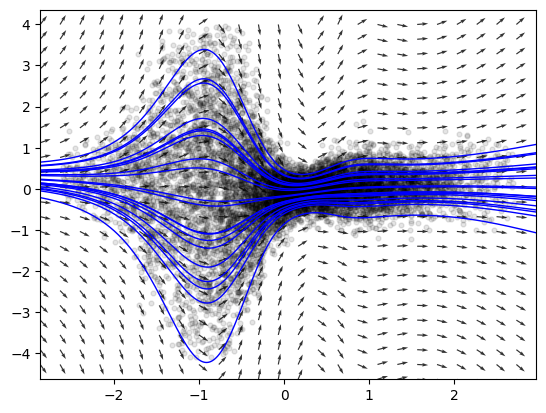

In [4]:
from plotting import plot_data
plot_data(x_data, y_data)
plot_flow(lsnm.flow_normalized,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (20,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (20,)), 
          n_pts = 1000,
          color = "blue")
plot_velocity_grid(jax.vmap(lsnm.velocity_normalized), n_pts = 25)

Fitting sample size: 100
Fitting sample size: 500
Fitting sample size: 1000
Fitting sample size: 5000
Fitting sample size: 10000


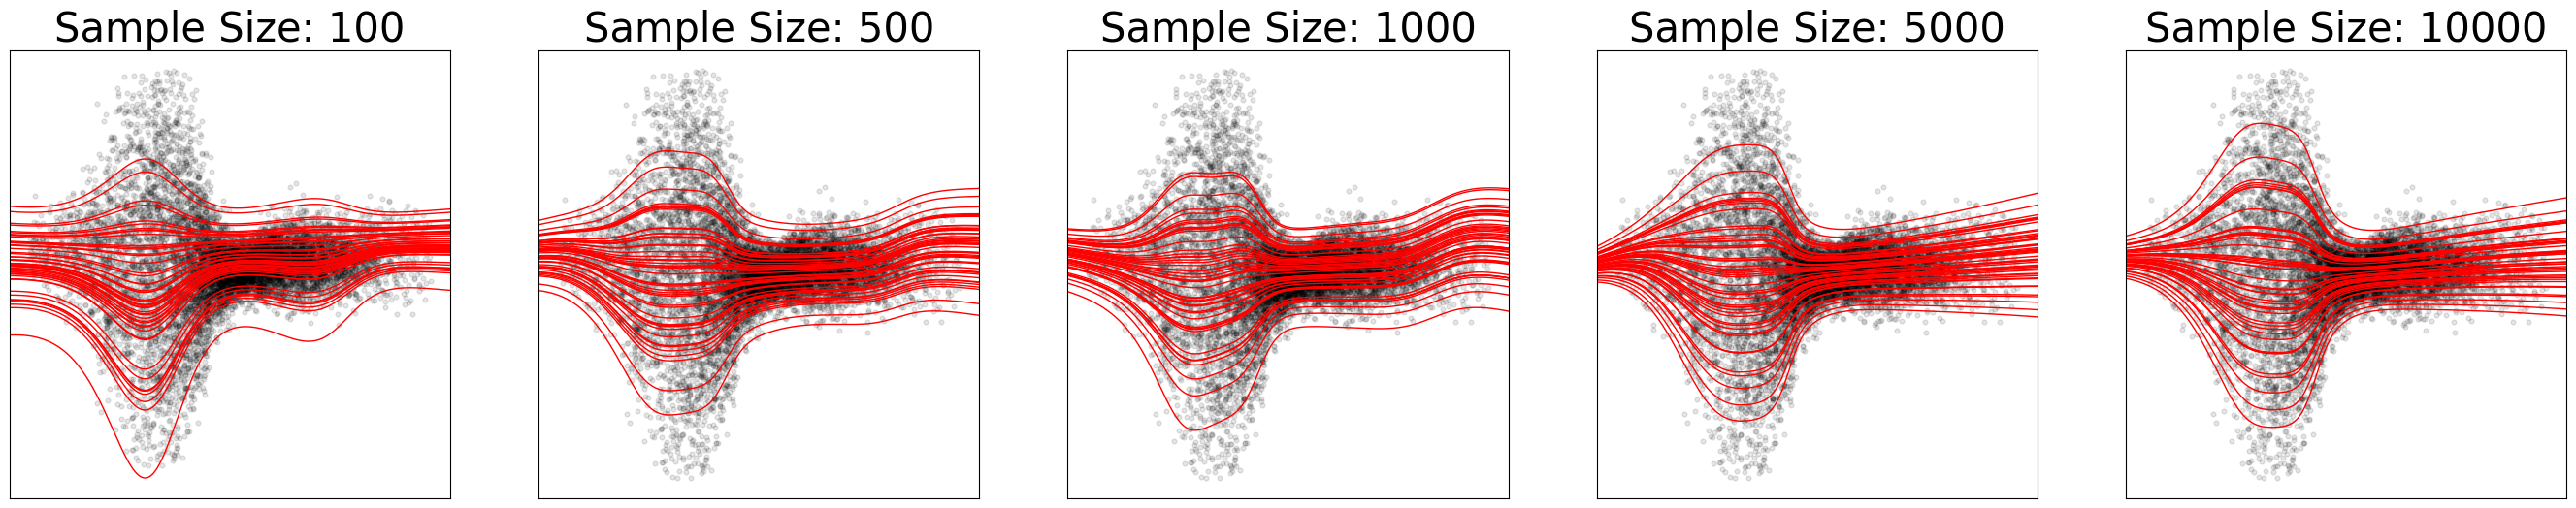

In [13]:
model = lsnm_model(layers = 2, hidden_size = 32)
params_init = model.params_init(seed = 444, init_weight = 0.1)

class estimated_flow(mechanism_from_flow):

    def __init__(self, model, params):
        super().__init__(stiff = True)
        self.model = model
        self.params = params

    def velocity(self, y, x):
        return self.model(y, x, self.params)

def fit_sample_size(sample_size, score = "stein"):
    idx = jax.random.choice(jax.random.PRNGKey(0), N_DATA, shape = (sample_size,), replace = False)

    if score == "gt":
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            sx_data = sx_data[idx],
                                                                                            sxy_data = sxy_data[idx],
                                                                                            sy_data = sy_data[idx],
                                                                                            n_steps = 250)
    else:
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            score = "stein",
                                                                                            kernel = "gauss",
                                                                                            n_steps = 250)
    est_fwd = estimated_flow(model, params_fwd)

    plot_data(x_data, y_data)
    plot_flow(est_fwd.flow,
            x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (50,)),
            y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (50,)), 
            color = "red")

    plt.xticks([])
    plt.yticks([])


sample_sizes = [100, 500, 1000, 5000, 10000]
fig, axes = plt.subplots(1, 5, figsize=(34, 6))

for i, sample_size in enumerate(sample_sizes):
    plt.subplot(1, 5, i + 1)
    print(f"Fitting sample size: {sample_size}")
    fit_sample_size(sample_size)
    plt.title(f"Sample Size: {sample_size}", fontsize=30)





 

In [ ]:
# plt.subplot(1, 5, 5)


Fitting sample size: 100
Fitting sample size: 500
Fitting sample size: 1000
Fitting sample size: 5000


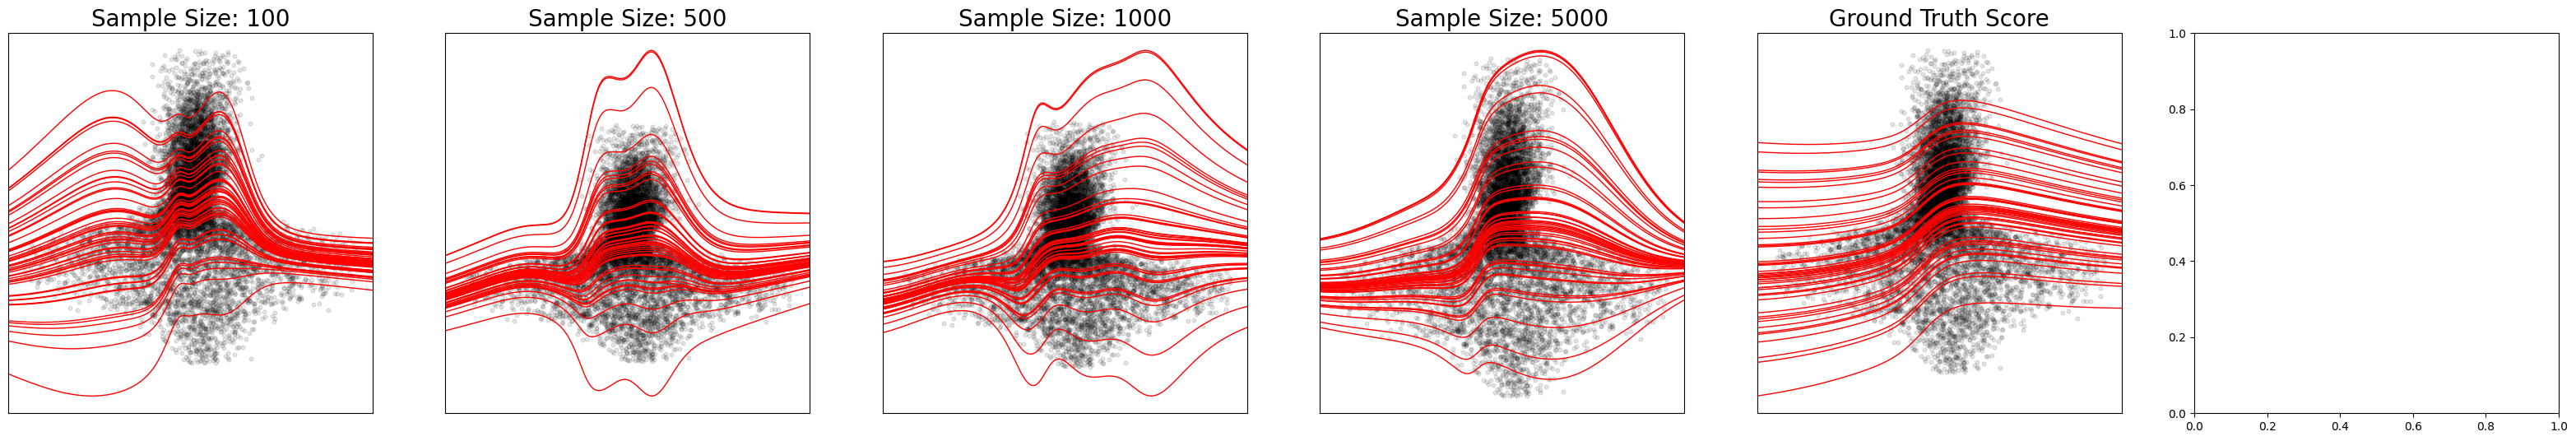

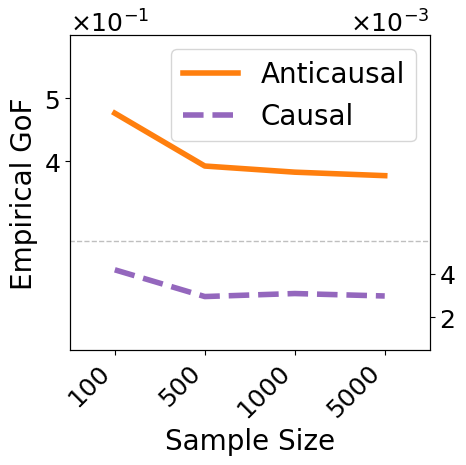

In [ ]:
model = lsnm_model()
params_init = model.params_init(seed = 444, init_weight = 0.1)


class estimated_flow(mechanism_from_flow):

    def __init__(self, model, params):
        super().__init__(stiff = True)
        self.model = model
        self.params = params

    def velocity(self, y, x):
        return self.model(y, x, self.params)

def fit_sample_size_bwd(sample_size, score = "stein"):
    idx = jax.random.choice(jax.random.PRNGKey(0), N_DATA, shape = (sample_size,), replace = False)

    if score == "gt":
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            sx_data = sx_data[idx],
                                                                                            sxy_data = sxy_data[idx],
                                                                                            sy_data = sy_data[idx],
                                                                                            n_steps = 250)
    else:
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            score = "stein",
                                                                                            kernel = "gauss",
                                                                                            n_steps = 250)
    est_fwd = estimated_flow(model, params_bwd)

    plot_data(y_data, x_data)
    plot_flow(est_fwd.flow,
            x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (50,)),
            y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (50,)), 
            color = "red")
    
    plt.xticks([])
    plt.yticks([])


sample_sizes = [100, 500, 1000, 5000]
fig, axes = plt.subplots(1, 6, figsize=(40, 6))

for i, sample_size in enumerate(sample_sizes):
    plt.subplot(1, 6, i + 1)
    print(f"Fitting sample size: {sample_size}")
    fit_sample_size_bwd(sample_size)
    plt.title(f"Sample Size: {sample_size}", fontsize=20)

plt.subplot(1, 6, 5)

# fit_sample_size_bwd(1000, score = "gt")  
# plt.title("Ground Truth Score", fontsize=20)

# plt.subplot(1, 6, 6)

 

([], [])

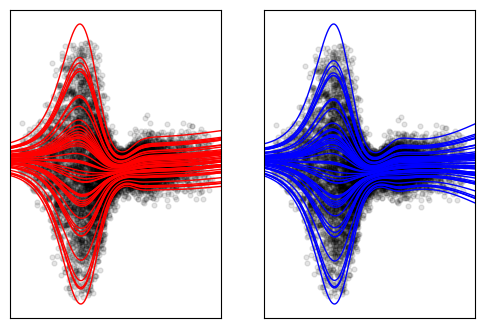

In [5]:
model = lsnm_model()
params_init = model.params_init(seed = 444, init_weight = 0.1)

def fit_sample_size(sample_size, score = "stein"):
    idx = jax.random.choice(jax.random.PRNGKey(0), N_DATA, shape = (sample_size,), replace = False)

    if score == "gt":
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            sx_data = sx_data[idx],
                                                                                            sxy_data = sxy_data[idx],
                                                                                            sy_data = sy_data[idx],
                                                                                            n_steps = 250)
    else:
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            score = "stein",
                                                                                            kernel = "gauss",
                                                                                            n_steps = 250)
    est_fwd = estimated_flow(model, params_fwd)

    plot_data(x_data, y_data)
    plot_flow(est_fwd.flow,
            x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (50,)),
            y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (50,)), 
            color = "red")

    plt.xticks([])
    plt.yticks([])

def fit_sample_size_bwd(sample_size, score = "stein"):
    idx = jax.random.choice(jax.random.PRNGKey(0), N_DATA, shape = (sample_size,), replace = False)

    if score == "gt":
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            sx_data = sx_data[idx],
                                                                                            sxy_data = sxy_data[idx],
                                                                                            sy_data = sy_data[idx],
                                                                                            n_steps = 250)
    else:
        gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                            params_init = params_init,
                                                                                            x_data = x_data[idx],
                                                                                            y_data = y_data[idx],
                                                                                            score = "stein",
                                                                                            kernel = "gauss",
                                                                                            n_steps = 250)
    est_fwd = estimated_flow(model, params_bwd)

    plot_data(y_data, x_data)
    plot_flow(est_fwd.flow,
            x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (50,)),
            y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (50,)), 
            color = "red")
    
    # plt.xlim(onp.min(y_data) - 0.5, onp.max(y_data) + 0.5)
    # plt.ylim(onp.min(x_data) - 20, onp.max(x_data) + 20)
    plt.xticks([])
    plt.yticks([])

fig = plt.figure(figsize=(6, 4))

plt.subplot2grid((1,2), (0,0))
fit_sample_size(1000, score = "gt")  

plt.subplot2grid((1,2), (0,1))
plot_data(x_data, y_data)
plot_flow(lsnm.flow_normalized,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (50,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (50,)), 
          color = "blue")

plt.xticks([])
plt.yticks([])

